In [18]:
import numpy as np
from scipy.stats import linregress

import pynbody

from michaels_functions import center_and_r_vir, remove_bulk_velocity, read_unit_from_info
from michaels_functions import s2, scrit, eff, a_stoa_m, s2m, scritm, effm, vec_transform
from scipy.interpolate  import griddata

from astropy.table import Table
# import lic
from licplot import lic_internal

import matplotlib.pyplot as plt
from matplotlib import rc, colors
from matplotlib import ticker, cm
import matplotlib.animation as animation
from matplotlib.artist import Artist
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

In [19]:
# New SF model data setting up
path = "/scratch/gpfs/eg2222/agora/eden-sf/output_00"
output='106'
data = pynbody.load(path + output)
data.physical_units()
omega_b, omega_m, unit_l, unit_d, unit_t = read_unit_from_info(data)

print(data.properties)
print(data.properties['time'].in_units('Myr'))

{'a': 1.0, 'omegaM0': 1.0, 'omegaL0': 0.0, 'h': 0.01, 'boxsize': Unit("3.20e+02 kpc"), 'time': Unit("1.44e+00 kpc s km**-1")}
1406.3477550069247


In [25]:
list(data.gas)

['scalar_02',
 'vz',
 'rho',
 'B_x_left',
 'metal',
 'B_y_right',
 'B_y_left',
 'B_z_left',
 'B_z_right',
 'scalar_01',
 'vx',
 'vel',
 'vy',
 'B_x_right',
 'p']

In [6]:
unit_v=unit_l/unit_t #cm/s
unit_b = np.sqrt(4*np.pi*unit_d)*unit_v #Gaussian units
gamma = 5./3.

data.gas['sigma1d'] = pynbody.array.SimArray(np.sqrt(2/3*data.gas['eturb'])*unit_v/1e5, 
                                             units='km s**-1')
data.gas['c_s'] = np.sqrt(gamma * data.gas['p'] / data.gas['rho'])
data.gas['M_s'] = data.gas['sigma1d'] / data.gas['c_s'].in_units('km s**-1')

# Magnetic field - cartesian components
data.gas['B_xc'] = 0.5 * (data.gas['bxl'] + data.gas['bxr']) * unit_b
data.gas['B_yc'] = 0.5 * (data.gas['byl'] + data.gas['byr']) * unit_b
data.gas['B_zc'] = 0.5 * (data.gas['bzl'] + data.gas['bzr']) * unit_b
data.gas['B2'] = data.gas['B_xc']**2 + data.gas['B_yc']**2 + data.gas['B_zc']**2
data.gas['B_norm'] = np.sqrt(data.gas['B2'])
# conversion to microGauss
data.gas['Bx_uG']=data.gas['B_xc'] * 1e6
data.gas['By_uG']=data.gas['B_yc'] * 1e6
data.gas['Bz_uG']=data.gas['B_zc'] * 1e6
data.gas['B_norm_uG'] = data.gas['B_norm'] * 1e6
data.gas['Bx_norm_uG']=np.abs(data.gas['Bx_uG'])
data.gas['By_norm_uG']=np.abs(data.gas['By_uG'])
data.gas['Bz_norm_uG']=np.abs(data.gas['Bz_uG'])

# Magnetic field - cylindrical components
data.gas['Brxy']=(data.gas['B_xc']*data.gas['x'].in_units('cm') + (data.gas['B_yc']*data.gas['y'].in_units('cm')))/data.gas['rxy'].in_units('cm')
data.gas['Btxy']=(data.gas['B_yc']*data.gas['x'].in_units('cm') - (data.gas['B_xc']*data.gas['y'].in_units('cm')))/data.gas['rxy'].in_units('cm')
# conversion to microGauss
data.gas['Brxy_uG'] = data.gas['Brxy'] * 1e6
data.gas['Btxy_uG'] = data.gas['Btxy'] * 1e6
data.gas['Bz_uG'] = data.gas['B_zc'] * 1e6

#Alvenic speed & beta values
data.gas['v_a'] = pynbody.array.SimArray(data.gas['B_norm'] / np.sqrt(4.*np.pi*data.gas['rho'].in_units('g cm**-3')), 
                                         units='cm s**-1')
data.gas['beta'] = (data.gas['c_s'].in_units('cm s**-1') / data.gas['v_a'])**2.

# convert everything to cgs units for computing alpha_virs and efficiencies
rho = data.gas['rho'].in_units('g cm**-3').view(type=np.ndarray)
dx = data.gas['smooth'].in_units('cm').view(type=np.ndarray)
G = float(pynbody.array.SimArray(6.67e-8, units='cm**3 g**-1 s**-2'))
c_s = data.gas['c_s'].in_units('cm s**-1').view(type=np.ndarray)
M_s = data.gas['M_s'].view(type=np.ndarray)
beta = data.gas['beta'].view(type=np.ndarray)

#Sonic/magnetic alpha_vir and efficiencies
data.gas['alpha_vir_s'] = (15. / np.pi) * (c_s**2. / (G * rho * dx**2.)) * (1. + M_s**2.)
data.gas['alpha_vir_m'] = a_stoa_m(data.gas['alpha_vir_s'].view(type=np.ndarray), 
                                   data.gas['M_s'].view(type=np.ndarray), 
                                   data.gas['beta'].view(type=np.ndarray))
data.gas['eff_s'] = eff(data.gas['alpha_vir_s'].view(type=np.ndarray), 
                        data.gas['M_s'].view(type=np.ndarray))
data.gas['eff_m'] = effm(data.gas['alpha_vir_s'].view(type=np.ndarray), 
                         data.gas['M_s'].view(type=np.ndarray), 
                         data.gas['beta'].view(type=np.ndarray))

KeyError: 'No array bxl for family gas'

/home/eg2222/.local/lib/python3.8/site-packages/pynbody/plot/sph.py:460: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return p.imshow(im[::-1, :].view(np.ndarray), extent=(-width / 2, width / 2, -width / 2, width / 2),


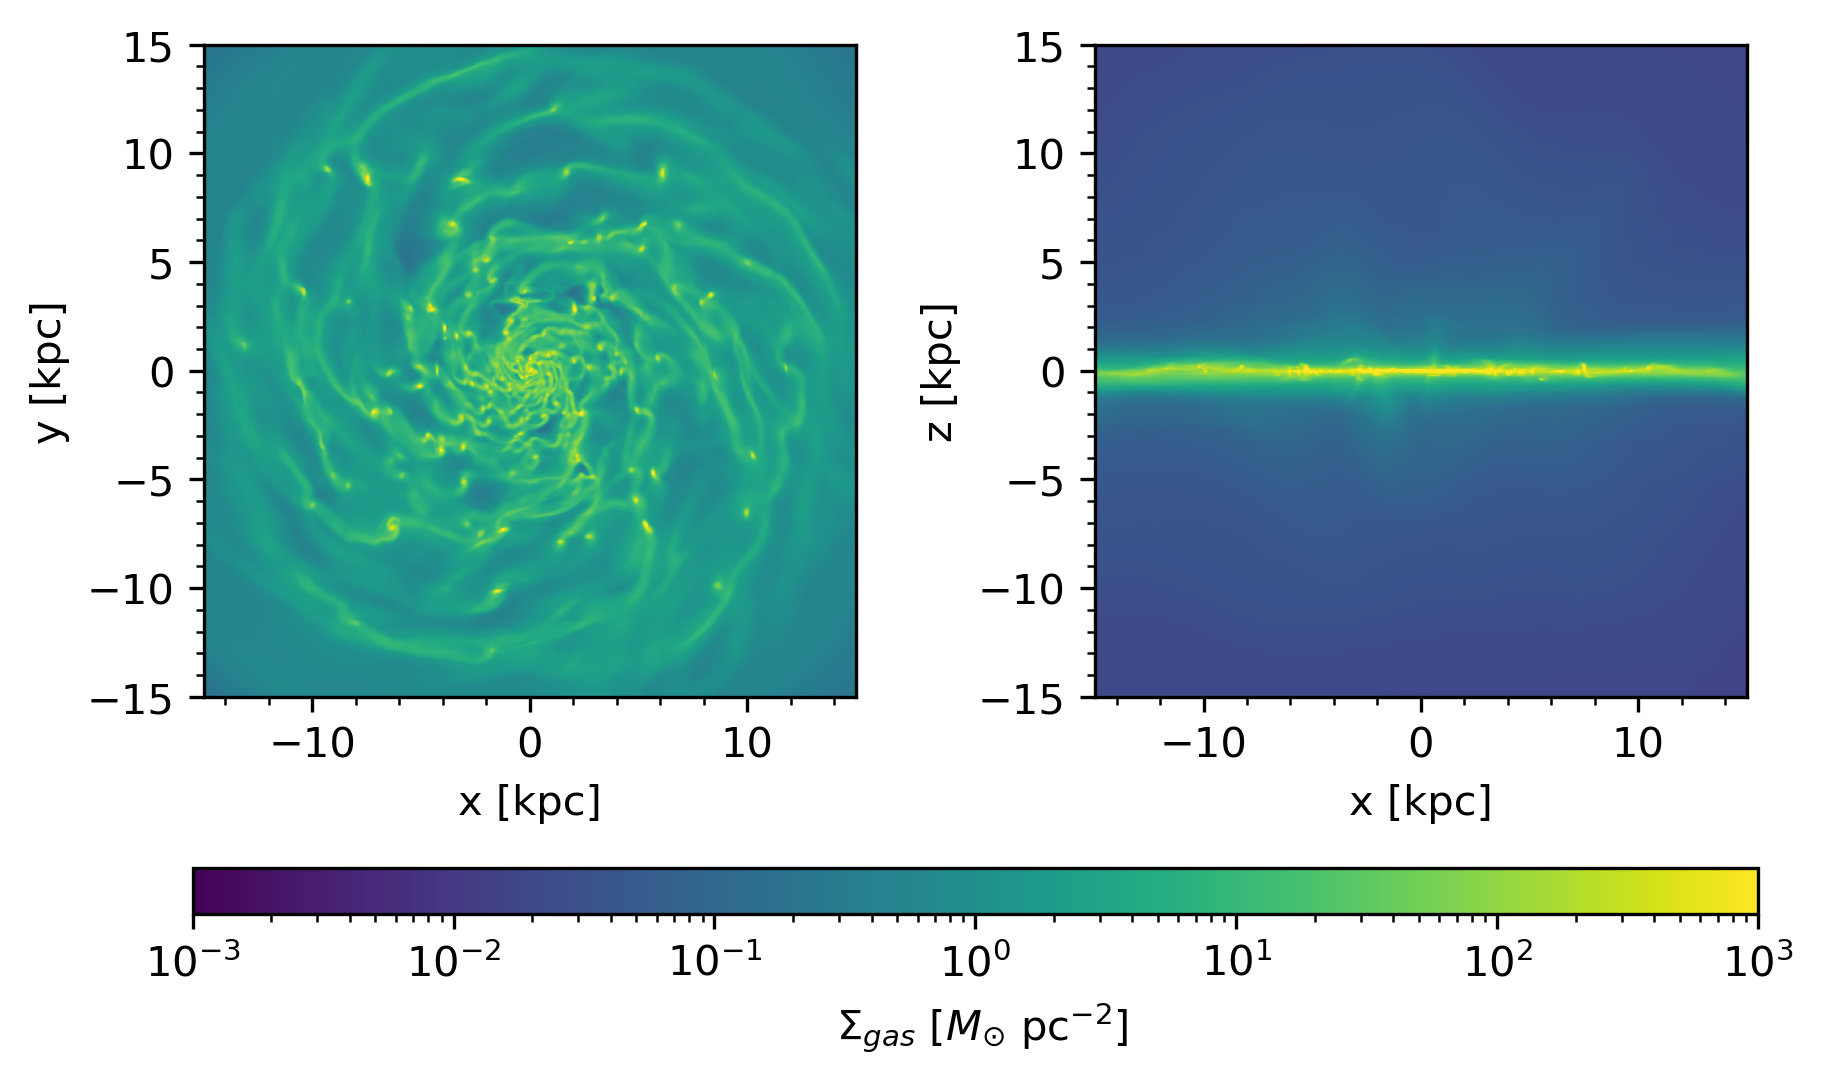

In [5]:
# Mapping gas surface density
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)

with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='rho', units='Msol pc**-2', width="%f kpc"%(30), ret_im=True,
                        log=True, resolution=500, vmin=1e-3, vmax=1e3, cmap="viridis",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='rho', units='Msol pc**-2', width="%f kpc"%(30), ret_im=True,
                        log=True, resolution=500, vmin=1e-3, vmax=1e3, cmap="viridis", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0,ax=axs, location='bottom', label=r" $\Sigma_{gas}$ $[M_{\odot}~\mathrm{pc}^{-2}]$")
# plt.savefig('plots/sigma_gas_map_new.pdf')
plt.show()

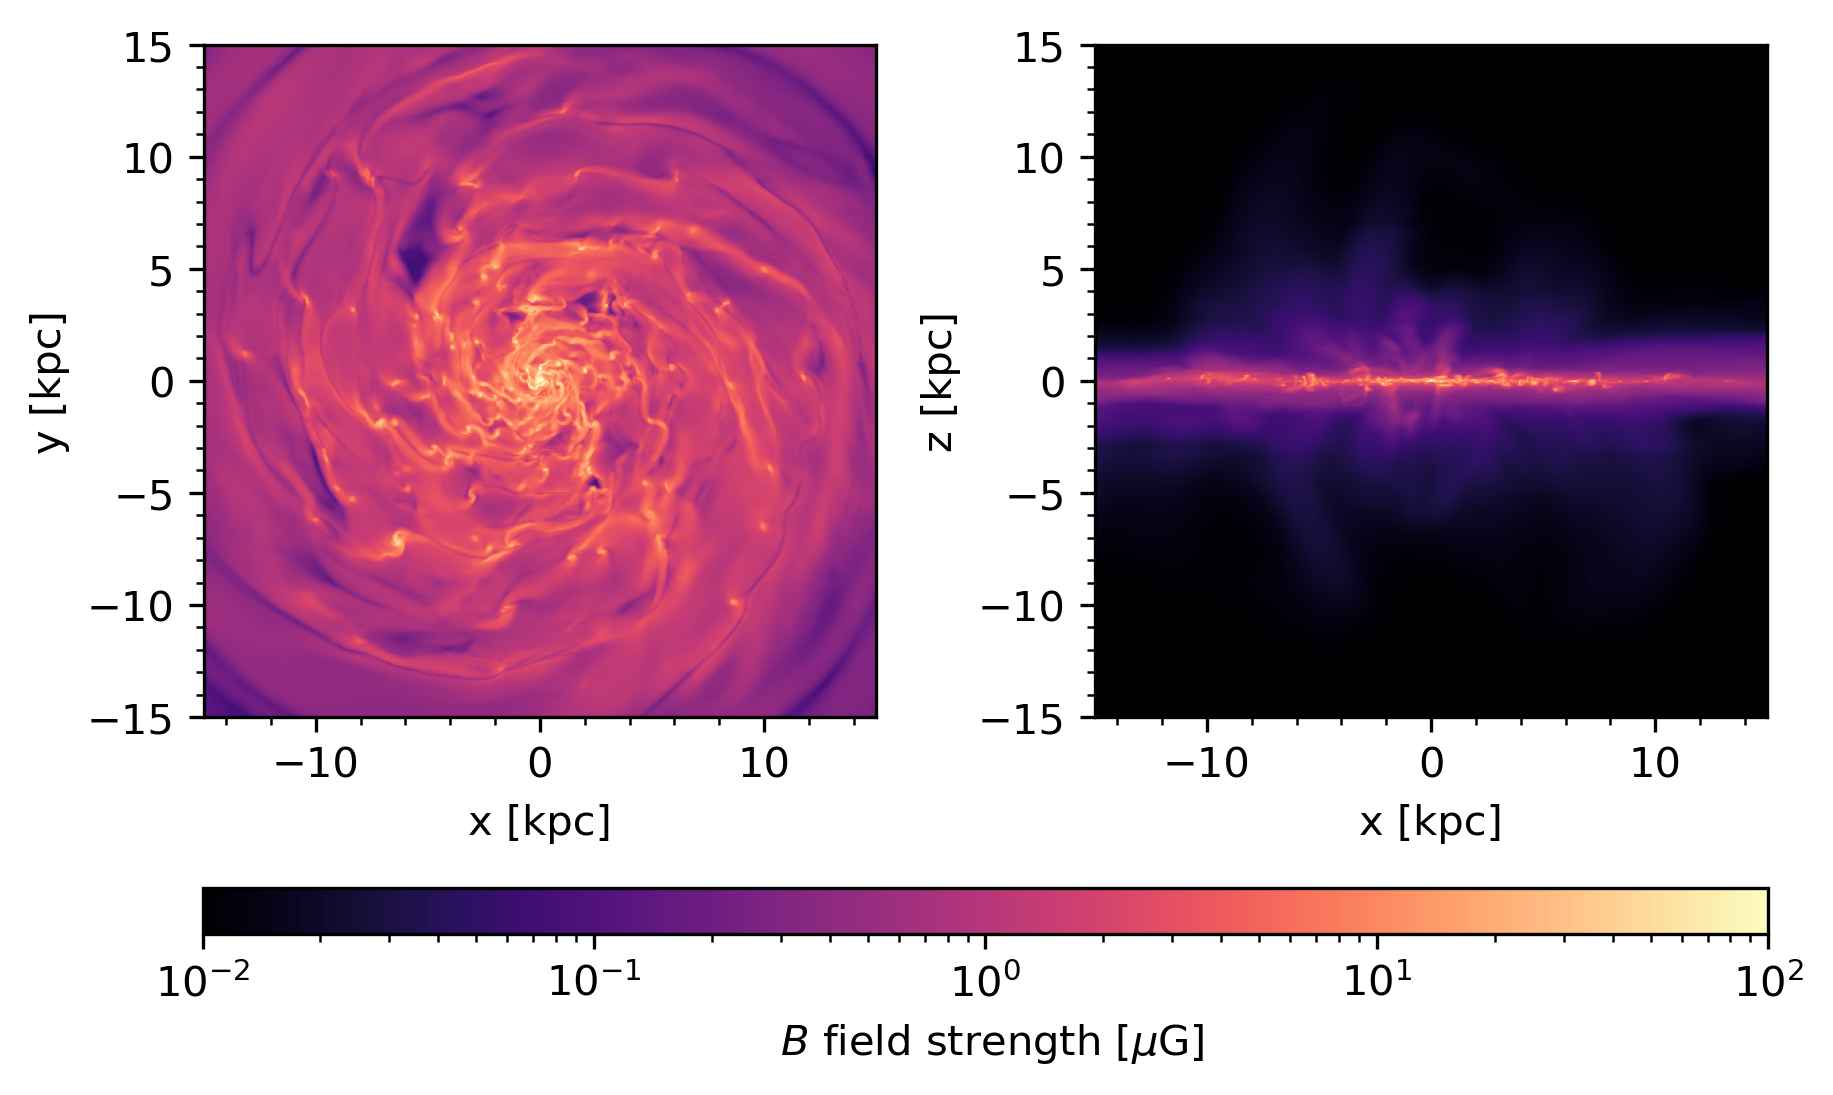

In [8]:
# Mapping B strength
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6,3.5), constrained_layout=True, dpi=300)

with pynbody.analysis.angmom.faceon(data):
    im0 = pynbody.plot.image(data.gas, qty='B_norm_uG', av_z='rho', width="%f kpc"%(30), ret_im=True,
                        log=True, resolution=500, vmin=1e-2, vmax=1e2, cmap="magma",    
                        subplot=axs[0],show_cbar=False)
    
with pynbody.analysis.angmom.sideon(data):
    im1 = pynbody.plot.image(data.gas,  qty='B_norm_uG', av_z='rho', width="%f kpc"%(30), ret_im=True,
                        log=True, resolution=500, vmin=1e-2, vmax=1e2, cmap="magma", 
                        subplot=axs[1],show_cbar=False)
    
axs[0].set_ylabel('y [kpc]')
axs[1].set_ylabel('z [kpc]')
for ax in axs.flatten():
    ax.set_xlabel('x [kpc]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.colorbar(im0,ax=axs, location='bottom', label=r" $B$ field strength [$\mu$G]")
# plt.savefig('plots/Bnorm_map_new.pdf')
plt.show()

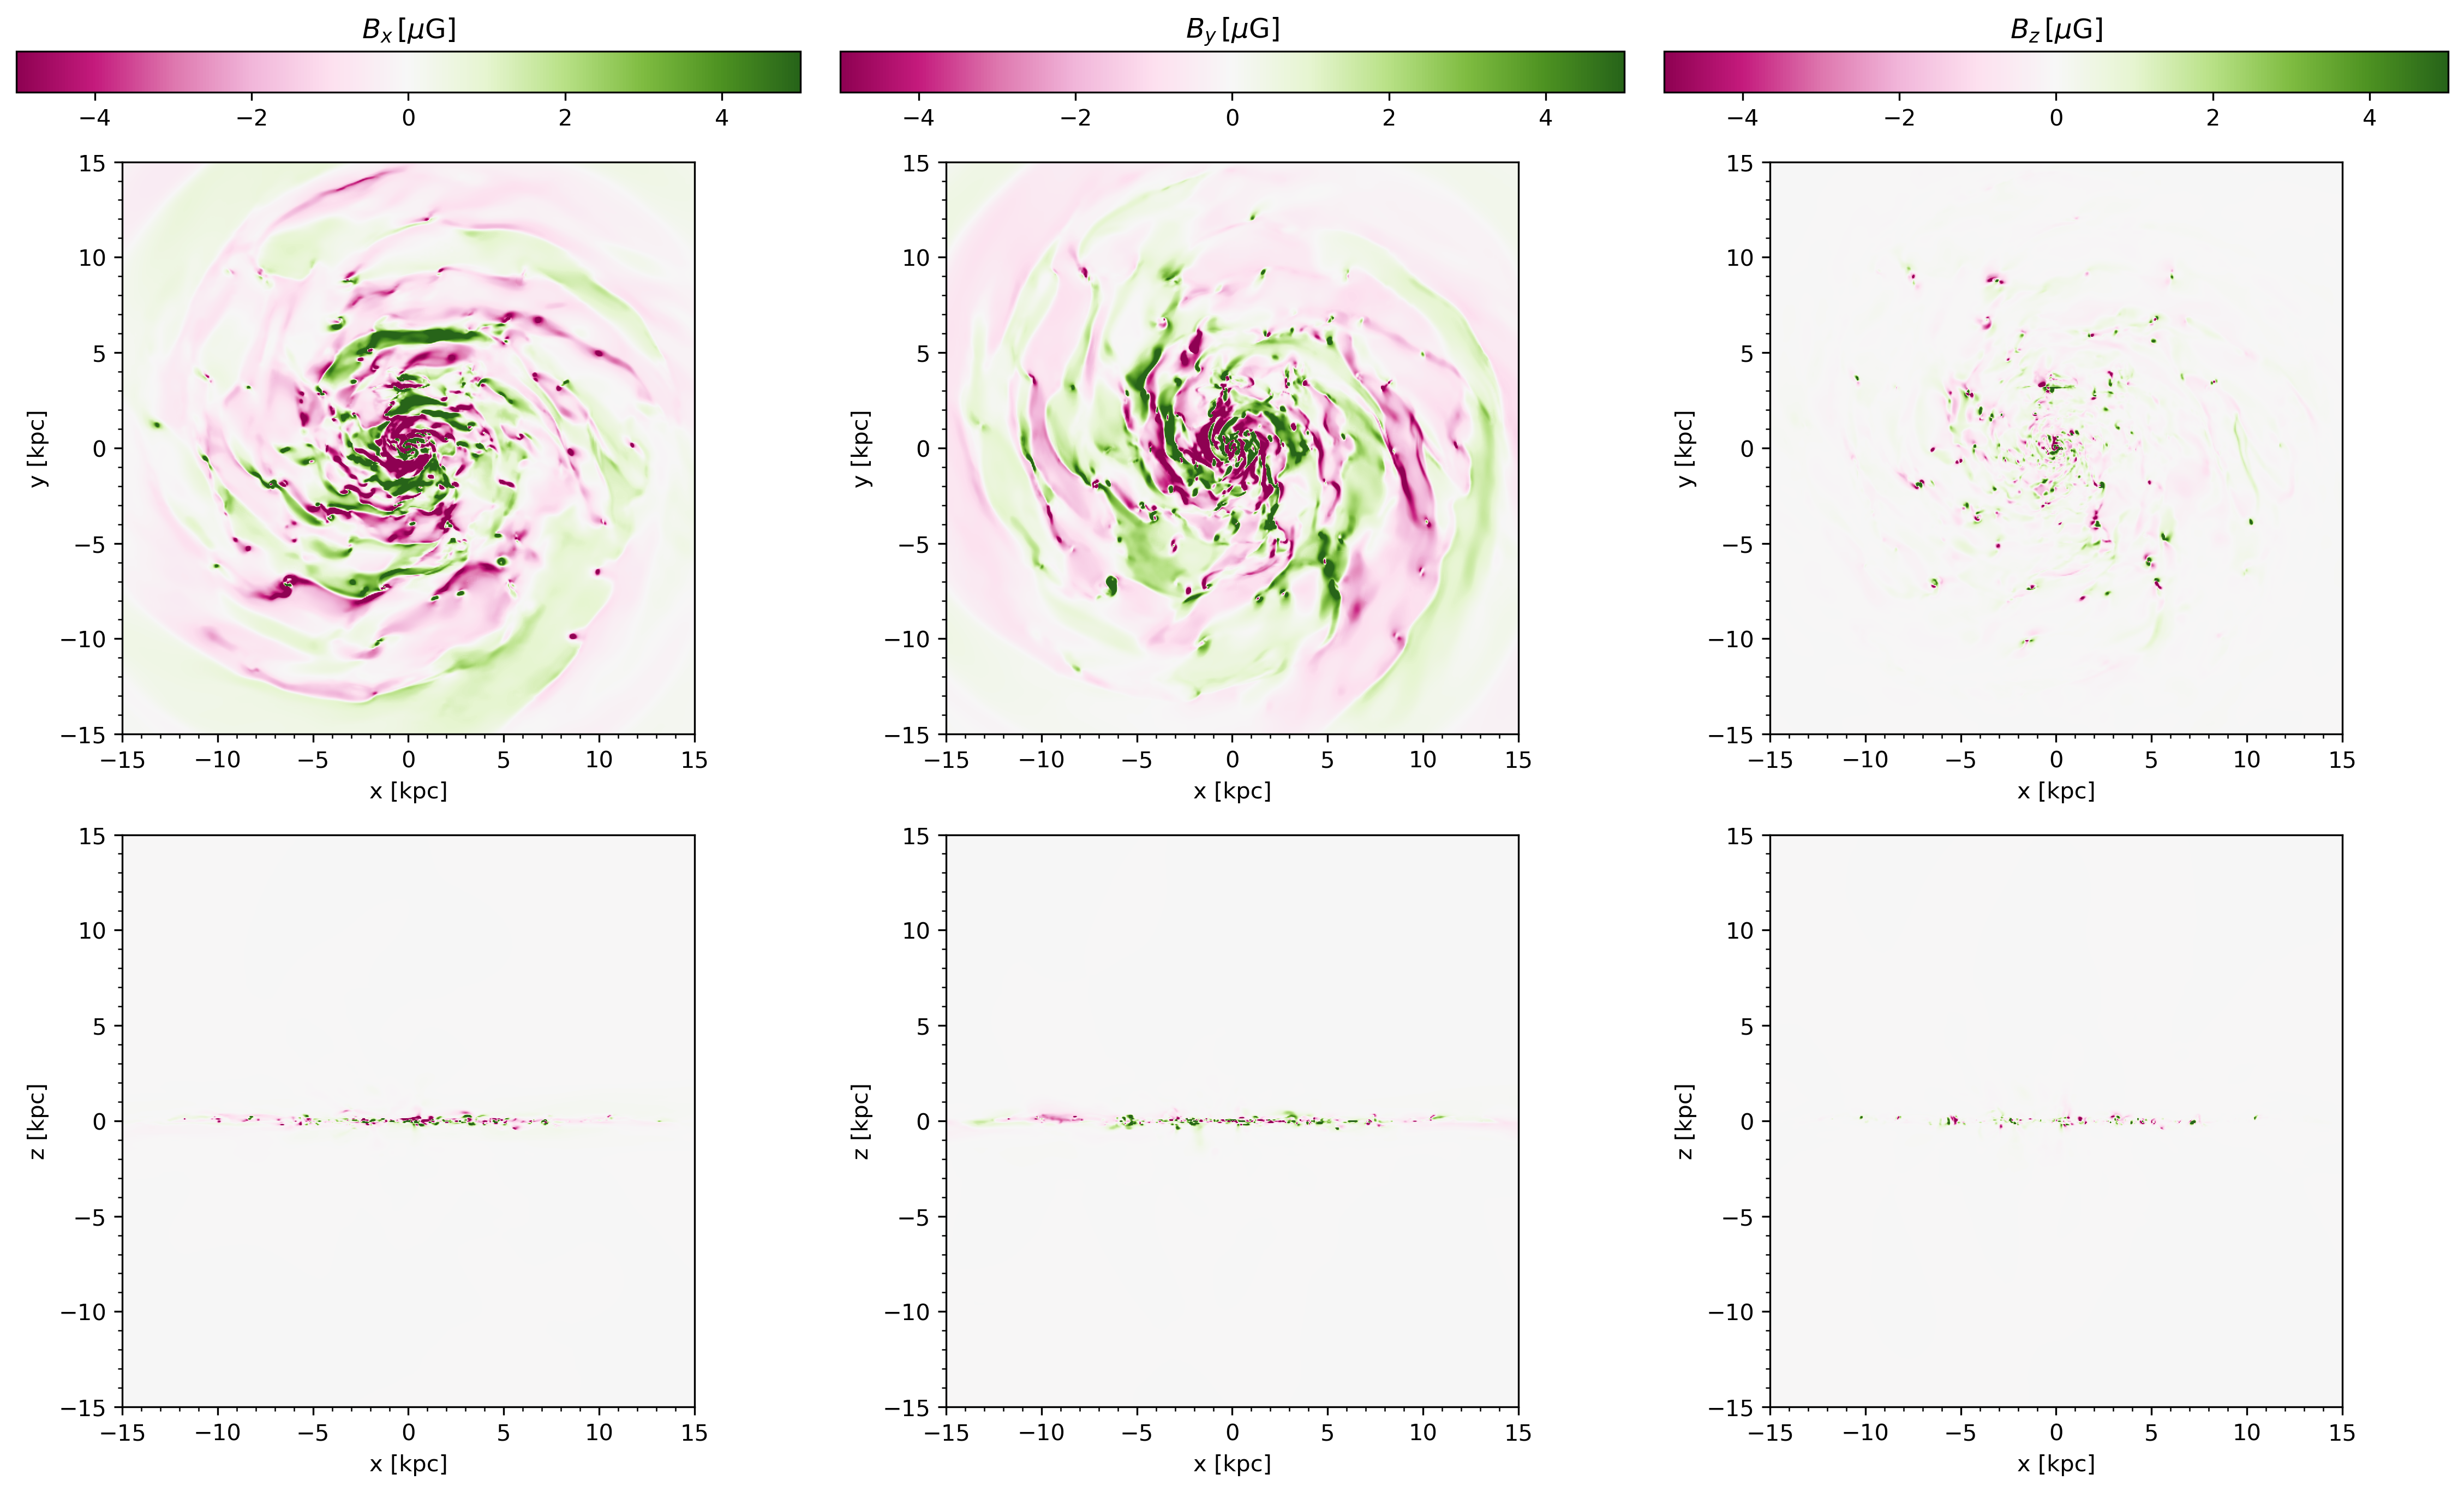

In [20]:
# Mapping B cartesian profiles

fig, axs = plt.subplots(nrows=3, ncols=3, dpi = 300, figsize=(15,9), constrained_layout=True,
                        gridspec_kw={'width_ratios':[1,1,1],'height_ratios':[1,14,14]})

vmin = -5
vmax = 5
with pynbody.analysis.angmom.faceon(data):
    im1 = pynbody.plot.image(data.gas, qty="Bx_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="PiYG", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[1,0])

    axs[1,0].set_ylabel('y [kpc]')
    axs[1,0].set_xlabel('x [kpc]')
    axs[0,0].set_title(r'$B_{x} \, [\mu \mathrm{G}]$')

    im2 = pynbody.plot.image(data.gas, qty="By_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="PiYG", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[1,1])
    axs[1,1].set_ylabel('y [kpc]')
    axs[1,1].set_xlabel('x [kpc]')
    axs[0,1].set_title(r'$B_{y} \, [\mu \mathrm{G}]$')

    im3 = pynbody.plot.image(data.gas, qty="Bz_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="PiYG", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[1,2])
    axs[1,2].set_xlabel('x [kpc]')
    axs[1,2].set_ylabel('y [kpc]')
    axs[0,2].set_title(r'$B_{z} \, [\mu \mathrm{G}]$')


with pynbody.analysis.angmom.sideon(data):
    im4 = pynbody.plot.image(data.gas, qty="Bx_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="PiYG", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[2,0])
    axs[2,0].set_ylabel('z [kpc]')
    axs[2,0].set_xlabel('x [kpc]')

    im5 = pynbody.plot.image(data.gas, qty="By_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="PiYG", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[2,1])
    axs[2,1].set_ylabel('z [kpc]')
    axs[2,1].set_xlabel('x [kpc]')
    
    im6 = pynbody.plot.image(data.gas, qty="Bz_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="PiYG", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[2,2])
    axs[2,2].set_xlabel('x [kpc]')
    axs[2,2].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

fig.colorbar(im1, cax=axs[0,0], orientation='horizontal')
fig.colorbar(im2, cax=axs[0,1], orientation='horizontal')
fig.colorbar(im3, cax=axs[0,2], orientation='horizontal')

# plt.savefig('plots/B_cart_map_new.pdf')
plt.show()

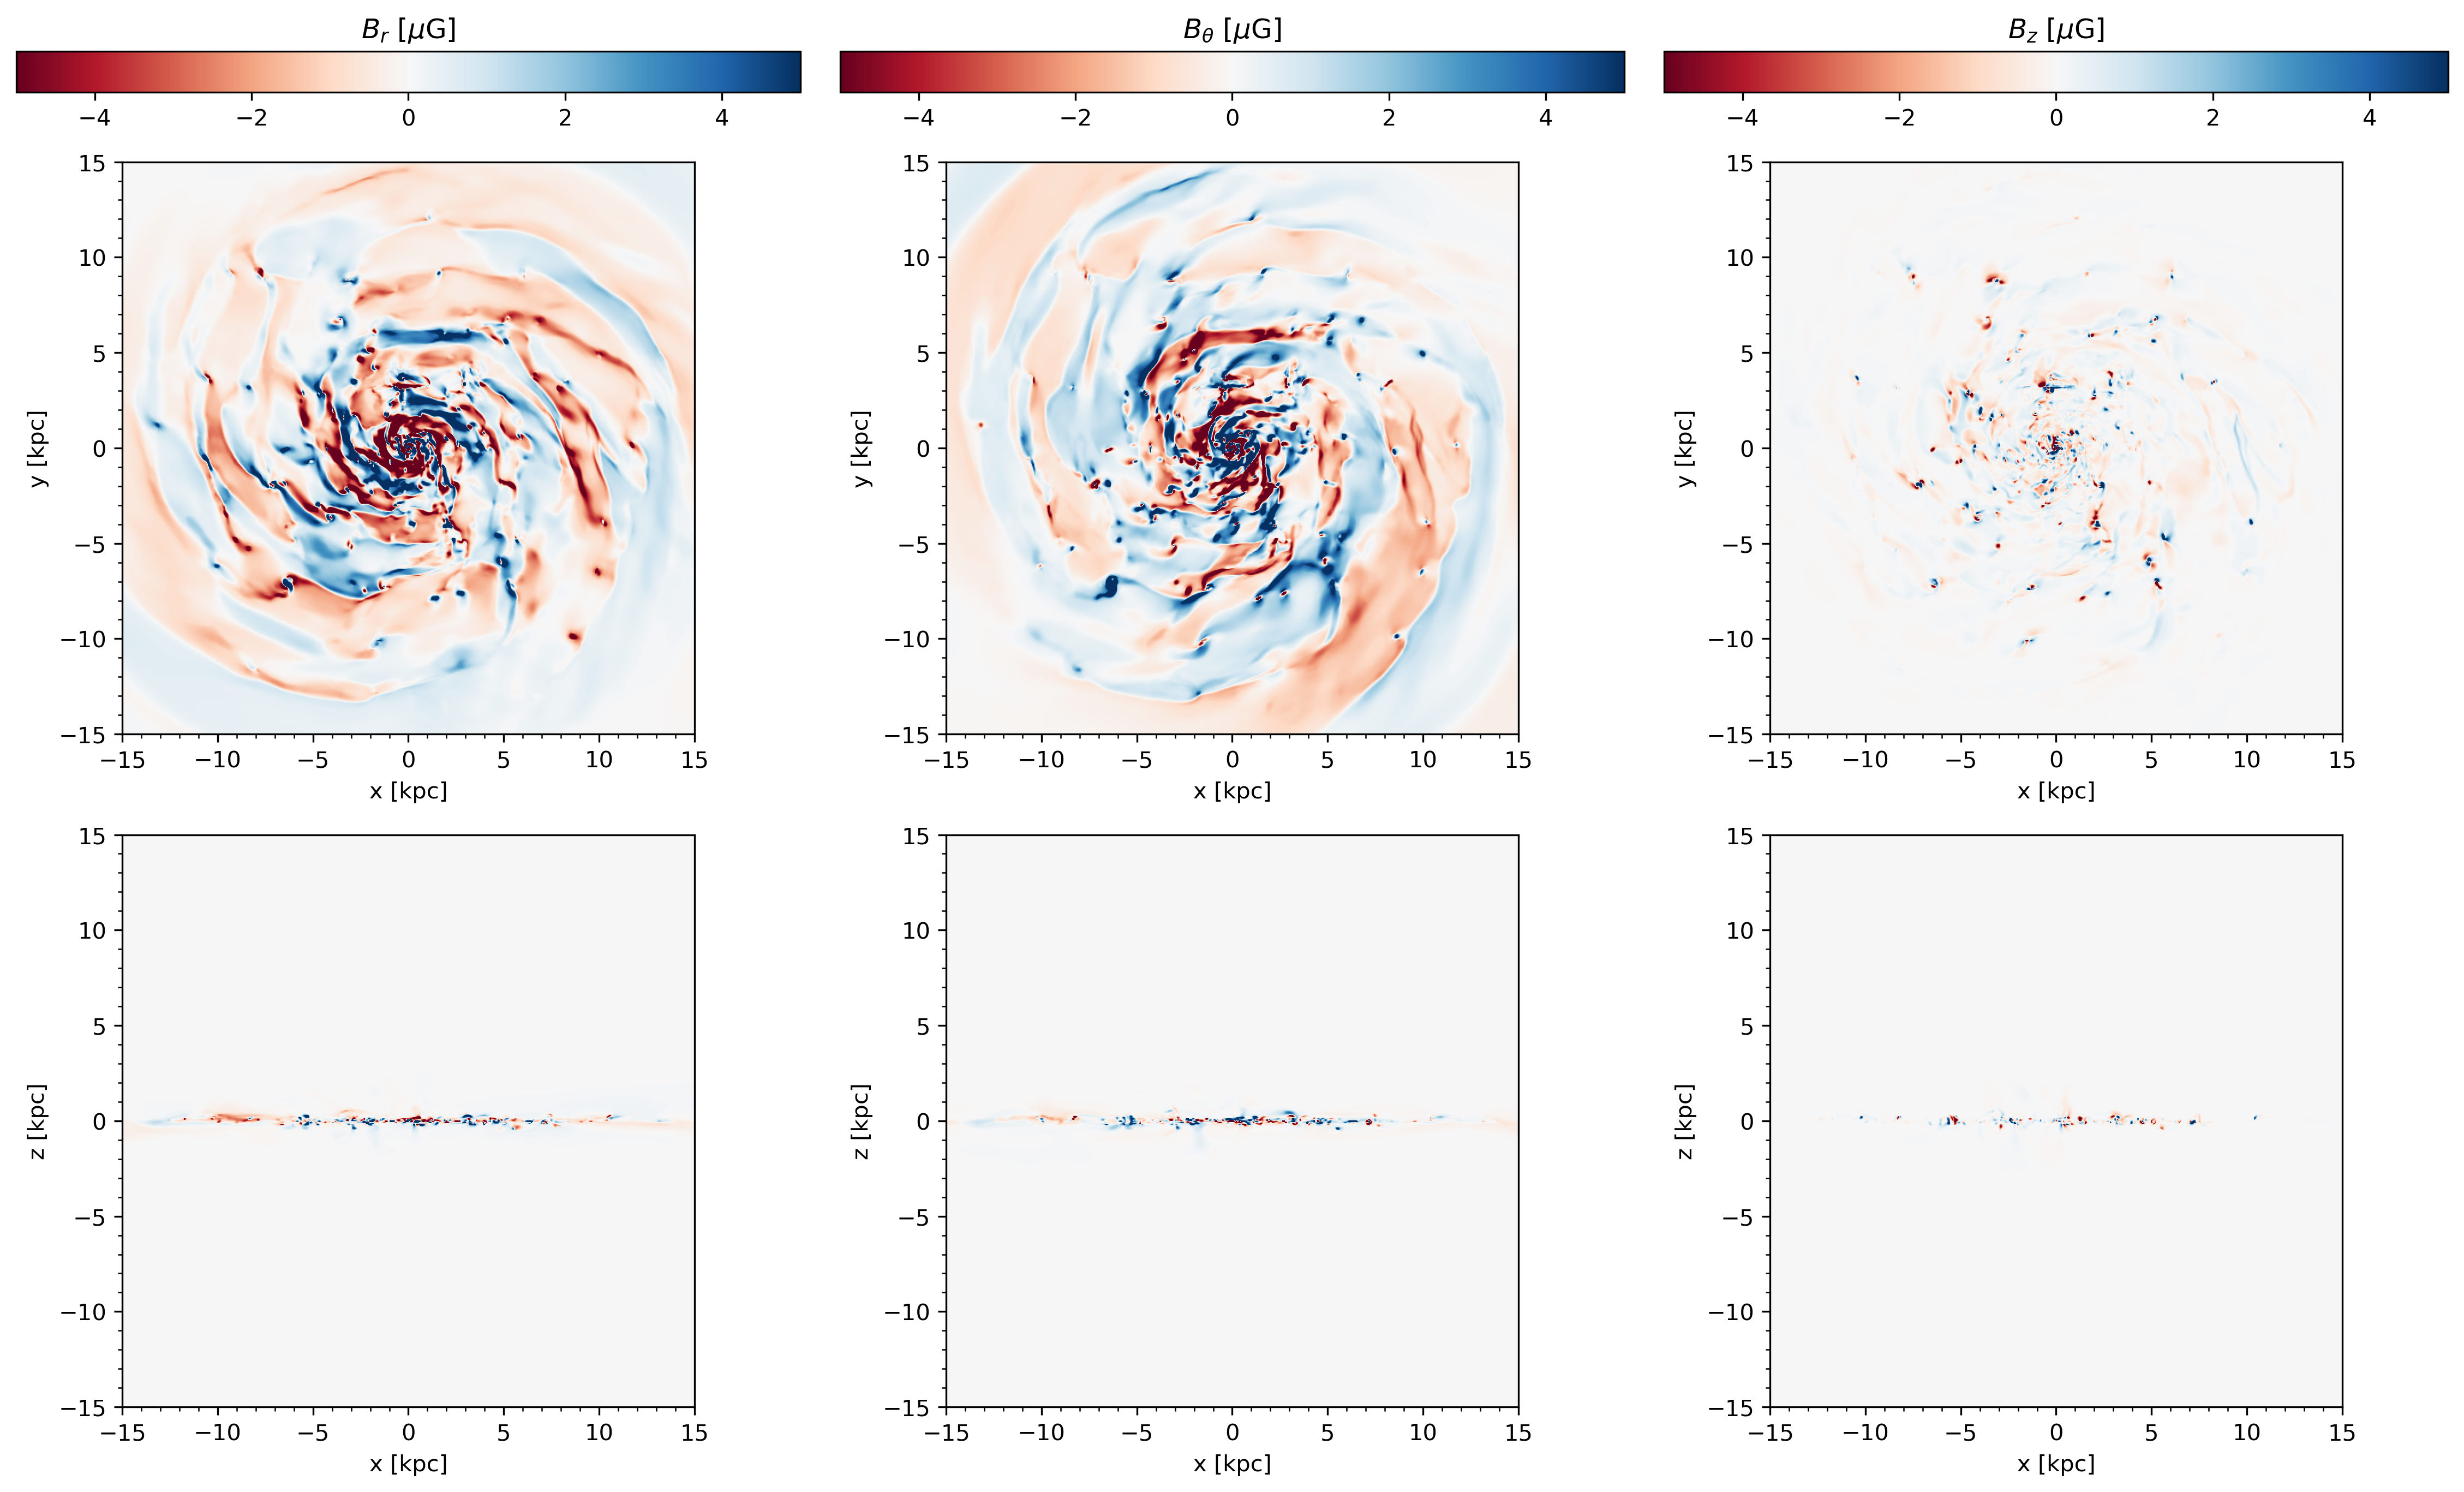

In [22]:
# Mapping B cylindrical profiles

fig, axs = plt.subplots(nrows=3, ncols=3, dpi = 300, figsize=(15,9), constrained_layout=True,
                        gridspec_kw={'width_ratios':[1,1,1],'height_ratios':[1,14,14]})

vmin = -5
vmax = 5

with pynbody.analysis.angmom.faceon(data):
    im1 = pynbody.plot.image(data.gas, qty="Brxy_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="RdBu", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[1,0])

    axs[1,0].set_ylabel('y [kpc]')
    axs[1,0].set_xlabel('x [kpc]')
    axs[0,0].set_title(r'$B_{r}$ [$\mu \mathrm{G}$]')

    im2 = pynbody.plot.image(data.gas, qty="Btxy_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="RdBu", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[1,1])
    axs[1,1].set_ylabel('y [kpc]')
    axs[1,1].set_xlabel('x [kpc]')
    axs[0,1].set_title(r'$B_{\theta}$ [$\mu \mathrm{G}$]')

    im3 = pynbody.plot.image(data.gas, qty="Bz_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="RdBu", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[1,2])
    axs[1,2].set_xlabel('x [kpc]')
    axs[1,2].set_ylabel('y [kpc]')
    axs[0,2].set_title(r'$B_{z}$ [$\mu \mathrm{G}$]')


with pynbody.analysis.angmom.sideon(data):
    im4 = pynbody.plot.image(data.gas, qty="Brxy_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="RdBu", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[2,0])
    axs[2,0].set_ylabel('z [kpc]')
    axs[2,0].set_xlabel('x [kpc]')

    im5 = pynbody.plot.image(data.gas, qty="Btxy_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="RdBu", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[2,1])
    axs[2,1].set_ylabel('z [kpc]')
    axs[2,1].set_xlabel('x [kpc]')
    
    im6 = pynbody.plot.image(data.gas, qty="Bz_uG", width="%f kpc"%(30), log=False,
                             resolution=500, cmap="RdBu", av_z='rho', ret_im=True,
                             vmin=vmin, vmax=vmax, show_cbar=False, subplot=axs[2,2])
    axs[2,2].set_xlabel('x [kpc]')
    axs[2,2].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

for i, im in enumerate([im1, im2, im3]):
    cbar = fig.colorbar(im, cax=axs[0,i], orientation='horizontal')
#     cbar.set_ticks(tick_locations)
#     cbar.set_ticklabels([mn,md,mx])

# plt.savefig('plots/B_cyln_map_new.pdf')
plt.show()

/home/eg2222/.local/lib/python3.8/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


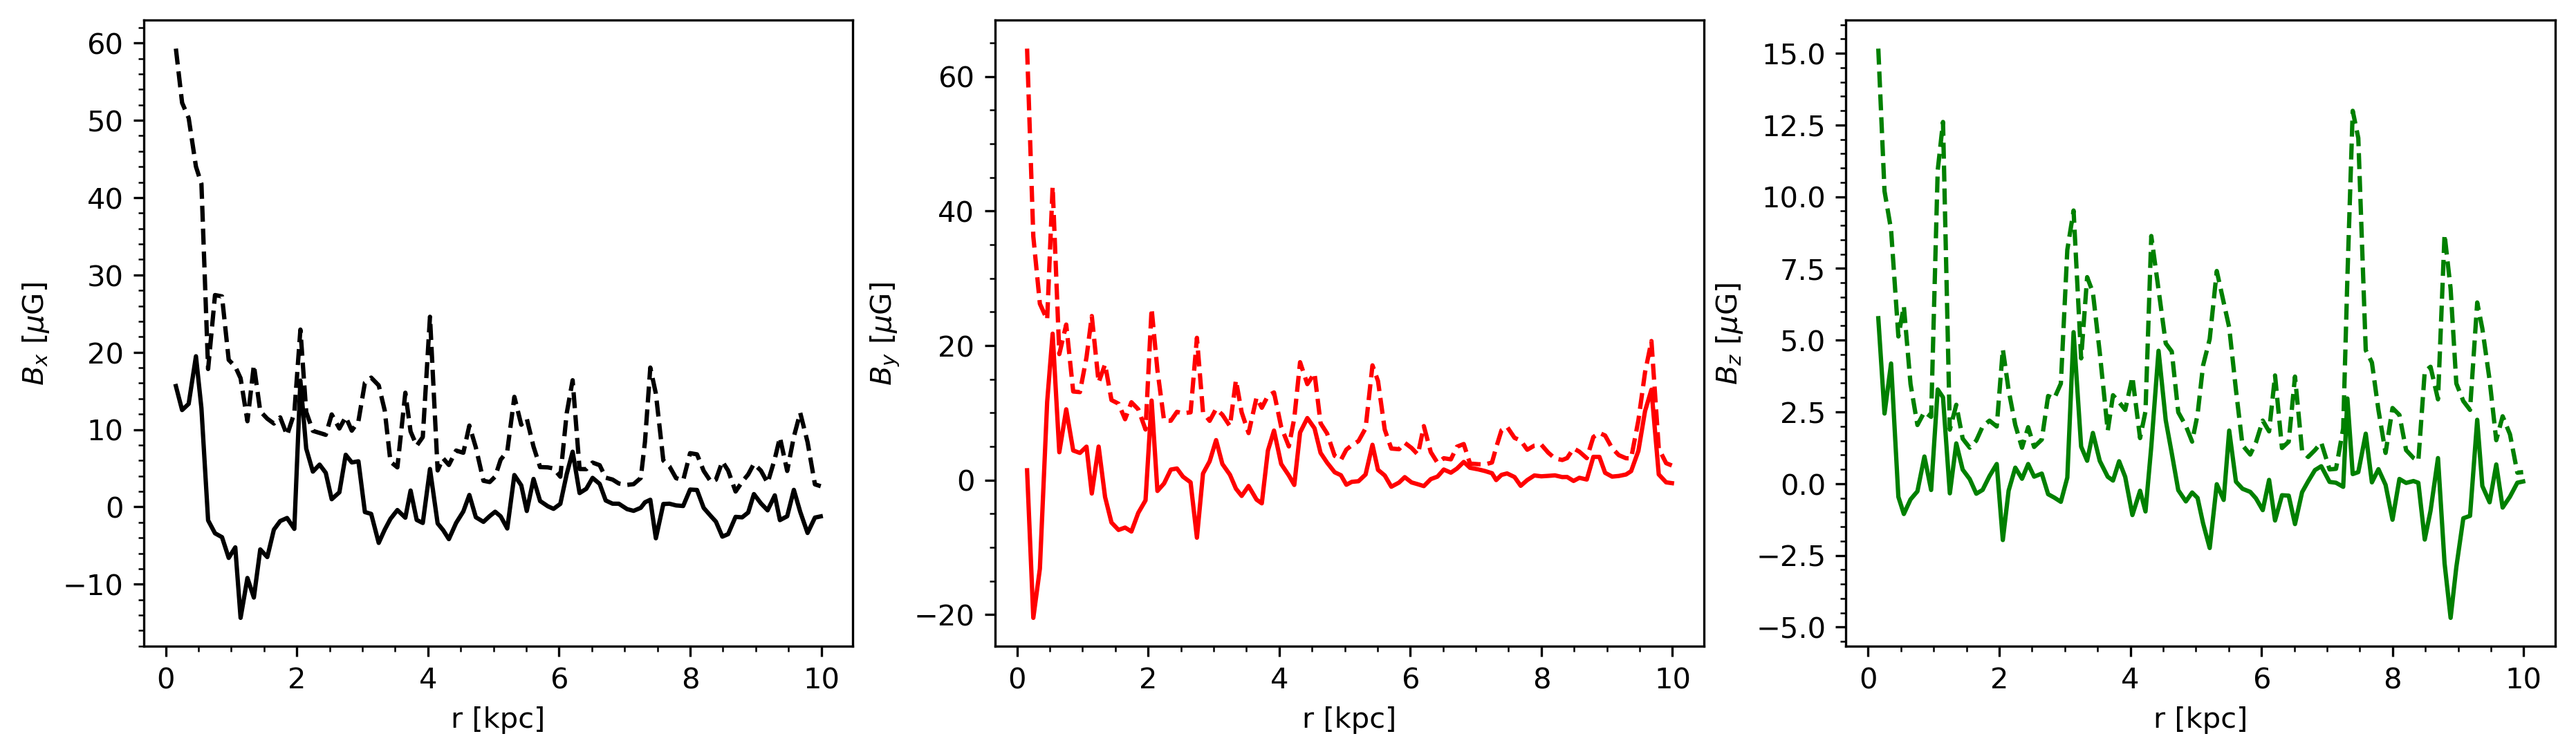

In [24]:
#B cartesian components in thin disk 

with pynbody.analysis.angmom.faceon(data):
    # create a profile object for the stars (by default this is a 2D profile)
    rmax=10
    hmax=33
    nbins=100
    disc = data[pynbody.filt.Disc(radius = '%f kpc' %(rmax), 
                                  height= '%f kpc' %(hmax))]
    
    p = pynbody.analysis.profile.Profile(disc.gas, rmin=0.1, nbins=nbins)
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,4), dpi=300)
    
    keys=np.array(['Bx_uG', 'By_uG', 'Bz_uG'])
    colors=np.array(['k','r','g'])
    xlabel='r [kpc]'
    ylabels=np.array([r'$B_{x}$ [$\mu$G]', r'$B_{y}$ [$\mu$G]', r'$B_{z}$ [$\mu$G]'])
    
    for i, ax in enumerate(axs.flatten()):
        ax.plot(p['r'], p[keys[i]], colors[i])
        ax.plot(p['r'], p[keys[i]+"_disp"], colors[i],ls='--')
        ax.set(xlabel=xlabel, ylabel=ylabels[i])
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
#     plt.savefig('plots/B_cart_prof_new.pdf')
    plt.show()

/home/eg2222/.local/lib/python3.8/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


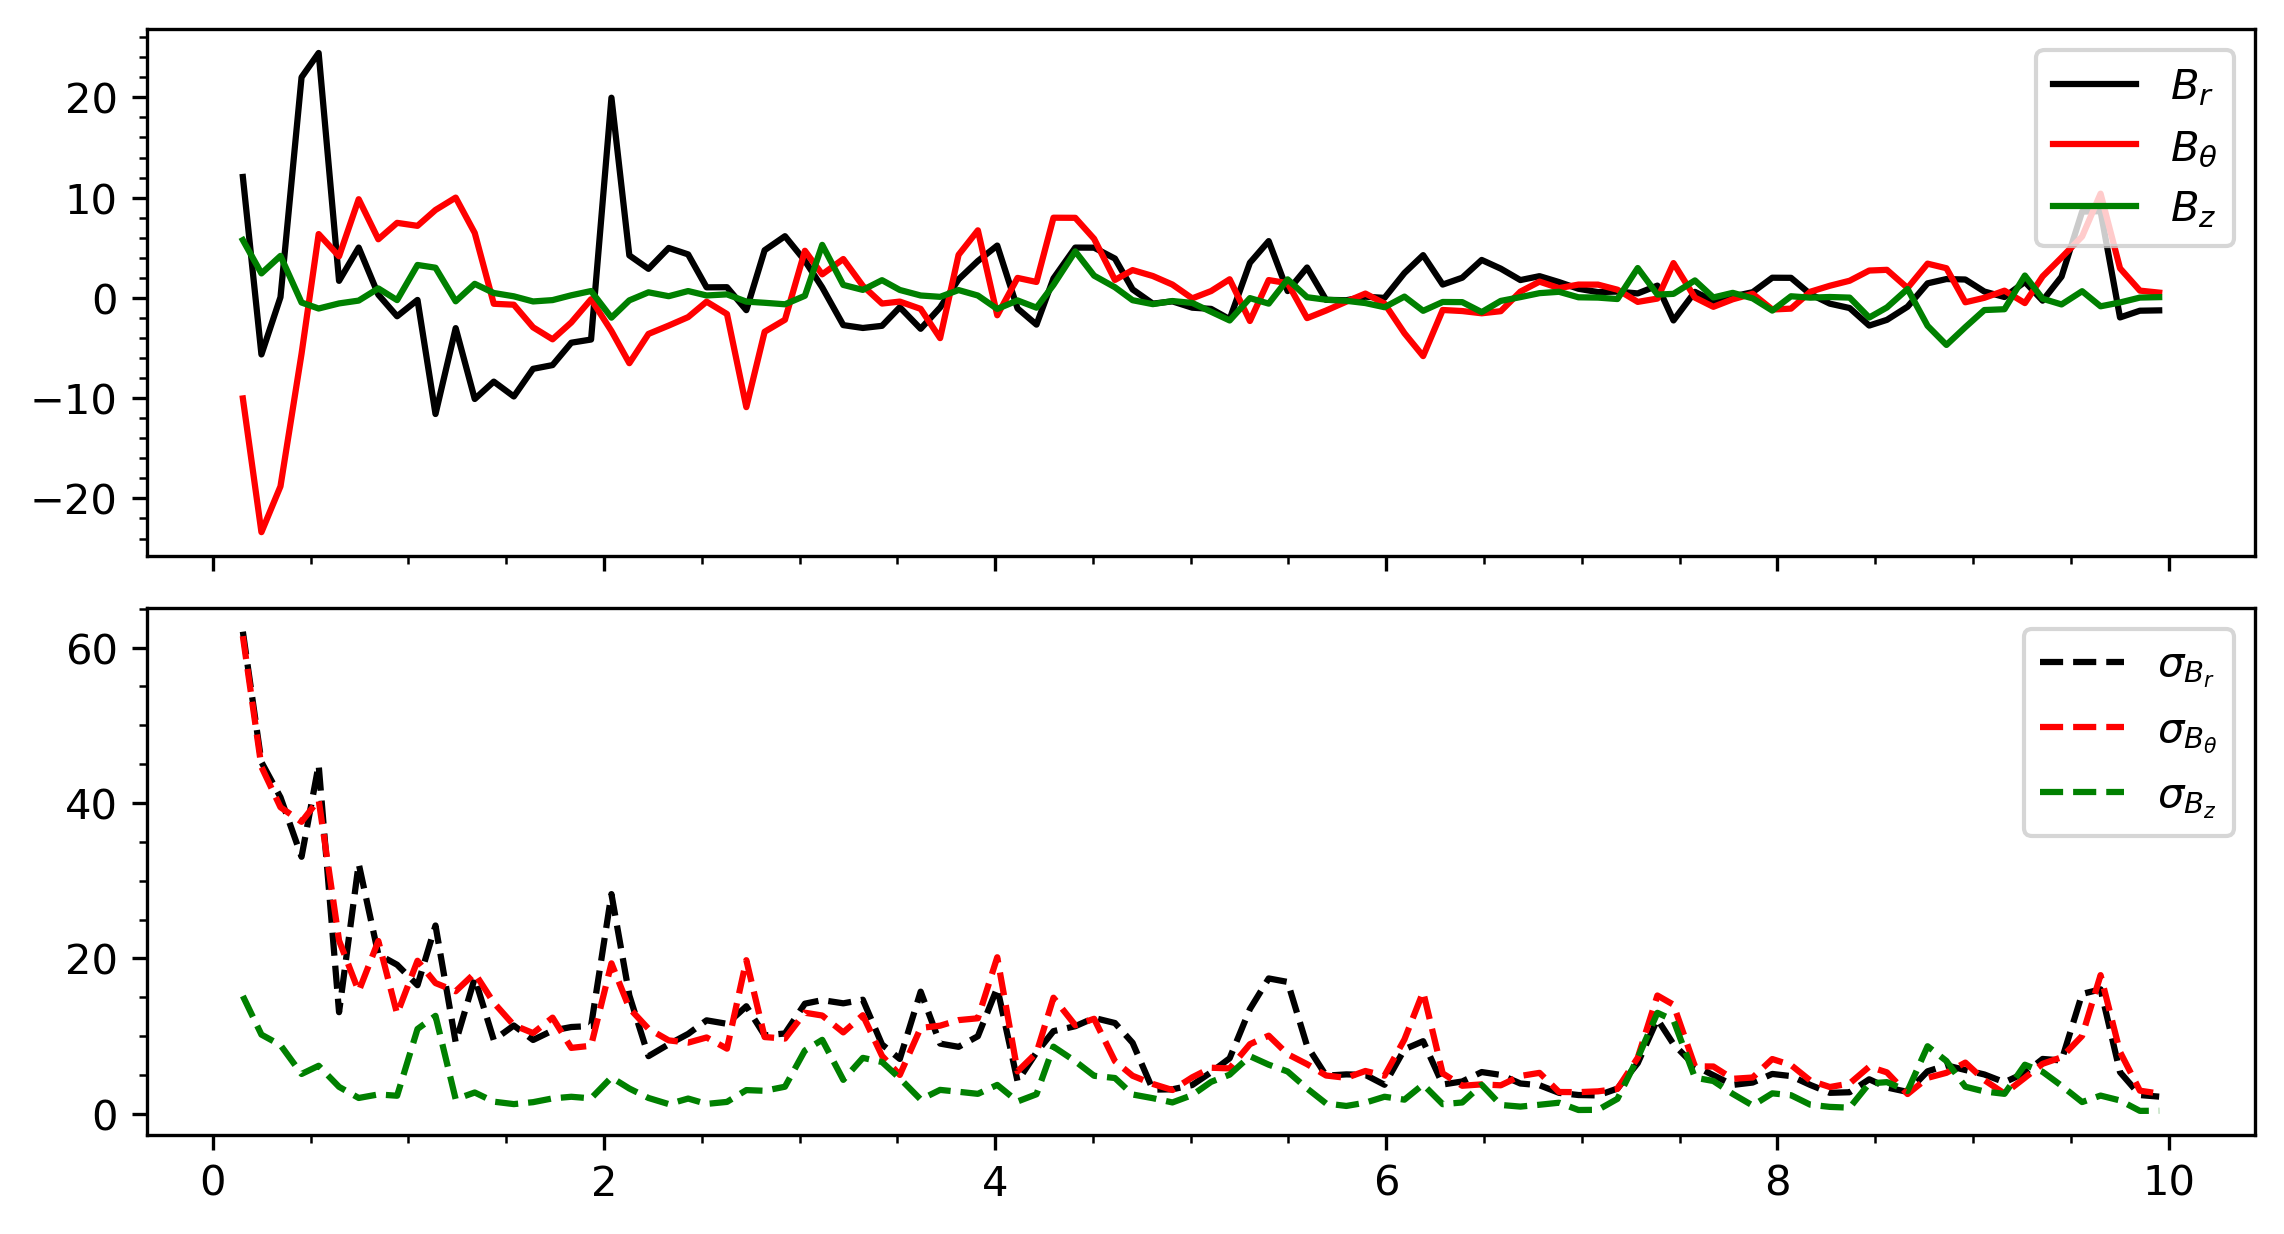

In [25]:
#B cylindrical components in thin disk 
with pynbody.analysis.angmom.faceon(data):
    rmax = 10.0
    hmax = 3.0
    disc = data[pynbody.filt.Disc(radius = '%f kpc' %(rmax), 
                                  height= '%f kpc' %(hmax))]
    
    p = pynbody.analysis.profile.Profile(disc.gas, rmin=0.1, nbins=100)
    
    fig, (ax1,ax2) = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=(7.5, 4), dpi=300)
    
    keys=np.array(['Brxy_uG', 'Btxy_uG', 'Bz_uG'])
    colors=np.array(['k','r','g'])
    xlabel='r [kpc]'
    ylabel=r'$B$ component[$\mu$G]'
    labels=np.array([r'$B_{r}$', r'$B_{\theta}$', r'$B_{z}$', 
                     r'$\sigma_{B_{r}}$', r'$\sigma_{B_{\theta}}$', 
                     r'$\sigma_{B_{z}}$'])
    
    for i, label in enumerate(labels):
        if i in [0,1,2]:
            ax1.plot(p['r'], p[keys[i]], colors[i], label=label)
        else:
            ax2.plot(p['r'], p[keys[i-3]+"_disp"], colors[i-3],ls='--', label=label)
    
    for ax in [ax1, ax2]:
#         ax.set(xlabel=xlabel, ylabel=ylabel)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.legend(loc='upper right')
#     plt.savefig('plots/B_cyln_prof_new.pdf')
    plt.show()

/home/eg2222/.local/lib/python3.8/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]


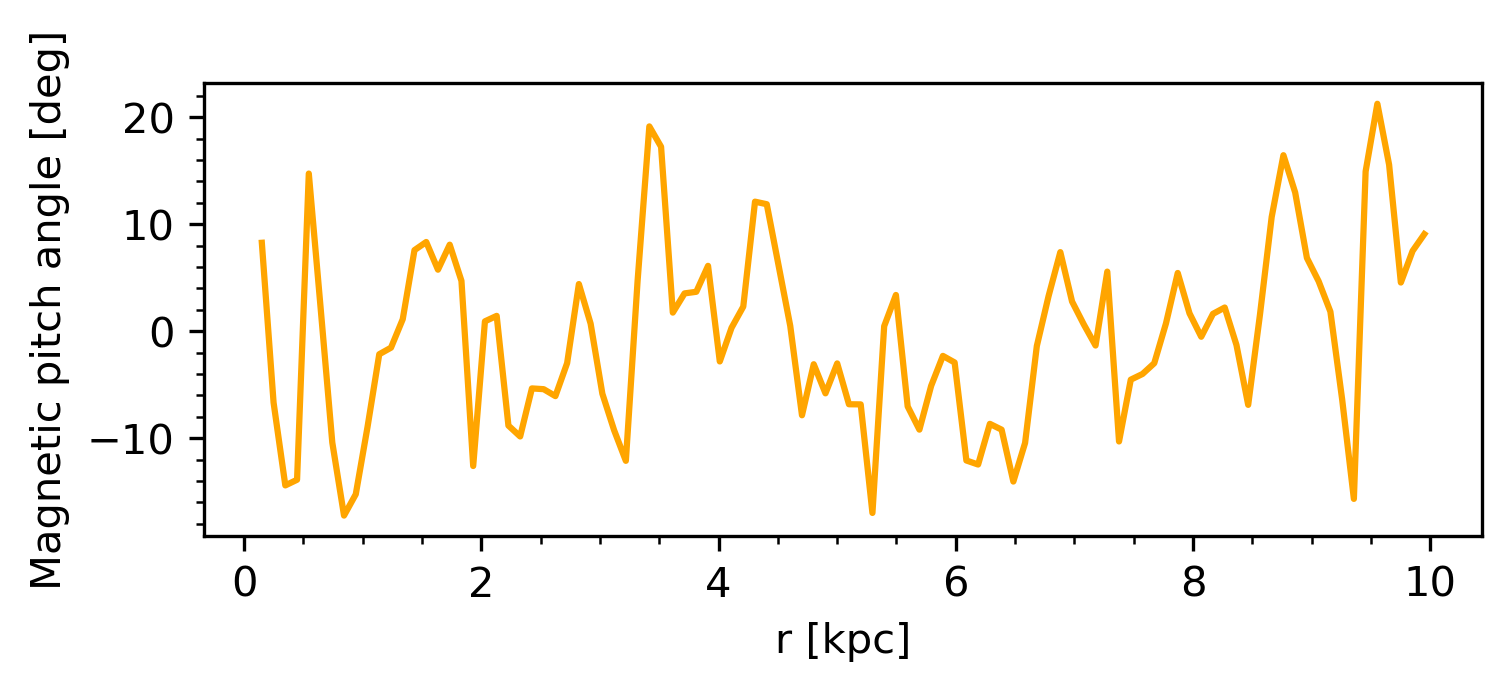

In [18]:
# Magnetic pitch angle

data.gas['pitch']=np.arctan(data.gas['Brxy']/data.gas['Btxy'])*(180./np.pi)    

with pynbody.analysis.angmom.faceon(data):
    # create a profile object for the stars (by default this is a 2D profile)
    rmax=10
    hmax=3
    disc = data[pynbody.filt.Disc(radius = '%f kpc' %(rmax), 
                                  height= '%f kpc' %(hmax))]
    p = pynbody.analysis.profile.Profile(disc.gas, rmin=0.1, nbins=100)
    
    # make the figure and sub plots
    f, ax = plt.subplots(figsize=(5.5,2), dpi=300)

    # make the plot
    ax.plot(p['rbins'], p['pitch'], 'orange')
    
#     ax.axhline(y=0,ls='--',c='k')
    
    ax.set_xlabel('r [kpc]')
    ax.set_ylabel(r'Magnetic pitch angle [deg]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
#     plt.savefig('plots/pitch_angle_new.pdf')
    plt.show()

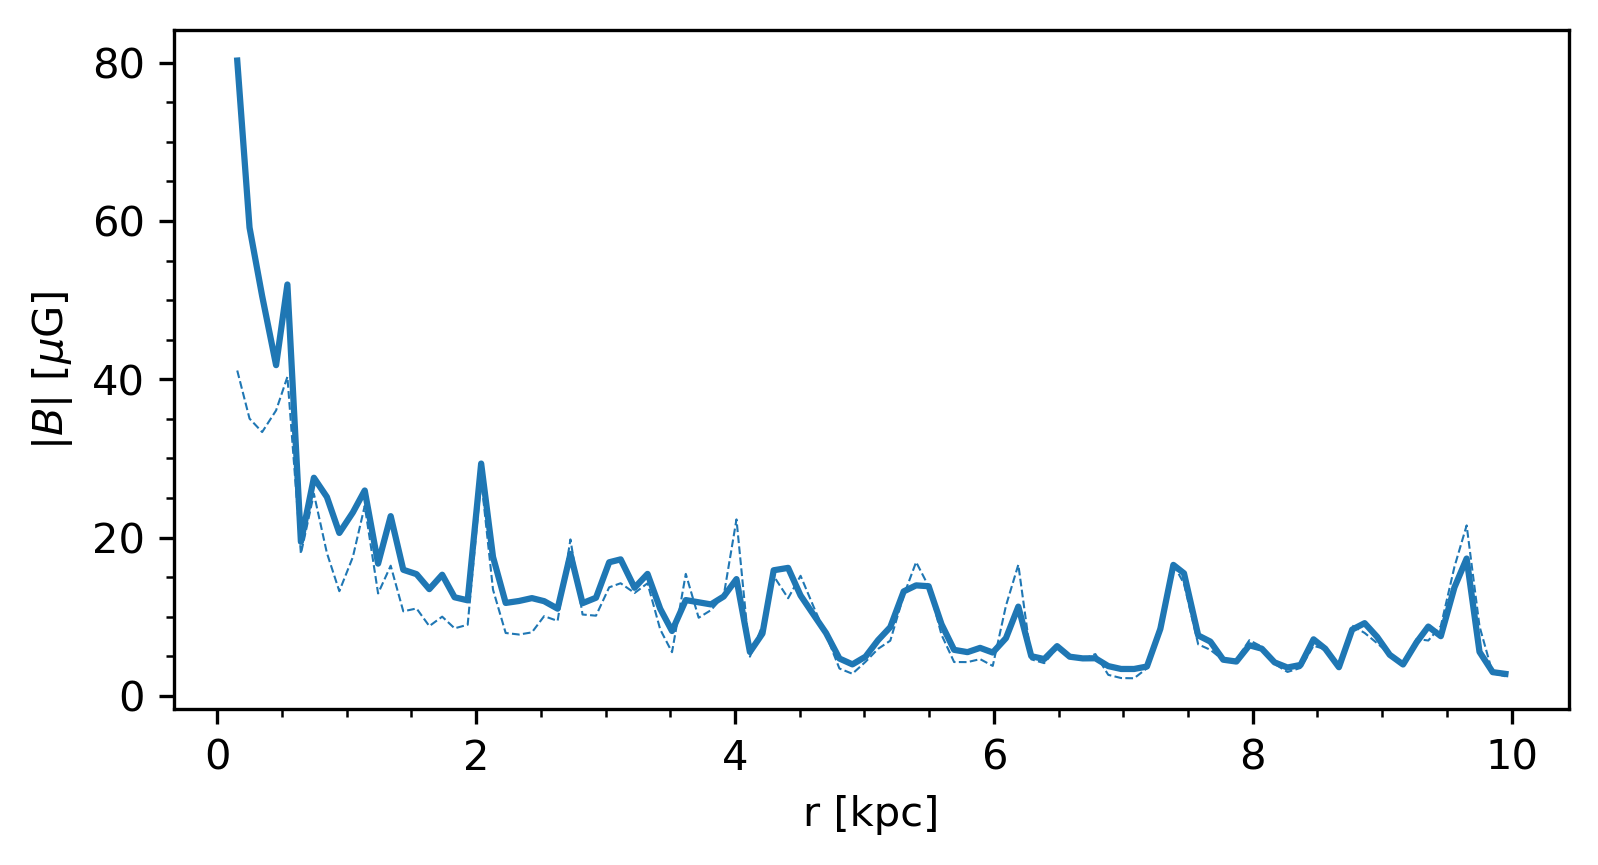

In [20]:
# B magnitude in thin disk

with pynbody.analysis.angmom.faceon(data):
    rmax = 10.0
    hmax = 3.0
    disc = data[pynbody.filt.Disc(radius = '%f kpc' %(rmax), 
                                  height= '%f kpc' %(hmax))]
    
    p = pynbody.analysis.profile.Profile(disc.gas, rmin=0.1, nbins=100)
    
    fig, ax = plt.subplots(figsize=(6,3), dpi=300)
    pl = ax.plot(p['r'], p['B_norm_uG'])
    c = pl[0].get_color()
    ax.plot(p['r'], p['B_norm_uG_disp'], ls='--', lw=0.5, color=c)
    
    ax.set(xlabel='r [kpc]', ylabel=r'$|B|$ [$\mu$G]')
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
    
    plt.savefig('plots/B_norm_prof_new.pdf')
    plt.show()

In [54]:
# Comparing Btheta growth over time
times=[]
outputs= ['006'] + [f'0{x}' for x in np.arange(16,106,10)]
datas=[]

for i, o in enumerate(outputs):
    d = pynbody.load(path + o)
    d.physical_units()
    datas.append(d)
    times.append(d.properties['time'].in_units('Myr'))

In [58]:
for i, dat in enumerate(datas):
    unit_v=unit_l/unit_t #cm/s
    unit_b = np.sqrt(4*np.pi*unit_d)*unit_v #Gaussian units
    gamma = 5./3.

    # Magnetic field - cartesian components
    dat.gas['B_xc'] = 0.5 * (dat.gas['bxl'] + dat.gas['bxr']) * unit_b
    dat.gas['B_yc'] = 0.5 * (dat.gas['byl'] + dat.gas['byr']) * unit_b
    dat.gas['B_zc'] = 0.5 * (dat.gas['bzl'] + dat.gas['bzr']) * unit_b
    dat.gas['B2'] = dat.gas['B_xc']**2 + dat.gas['B_yc']**2 + dat.gas['B_zc']**2
    dat.gas['B_norm'] = np.sqrt(dat.gas['B2'])
    # conversion to microGauss
    dat.gas['Bx_uG']=dat.gas['B_xc'] * 1e6
    dat.gas['By_uG']=dat.gas['B_yc'] * 1e6
    dat.gas['Bz_uG']=dat.gas['B_zc'] * 1e6
    dat.gas['B_norm_uG'] = dat.gas['B_norm'] * 1e6
    dat.gas['Bx_norm_uG']=np.abs(dat.gas['Bx_uG'])
    dat.gas['By_norm_uG']=np.abs(dat.gas['By_uG'])
    dat.gas['Bz_norm_uG']=np.abs(dat.gas['Bz_uG'])

    # Magnetic field - cylindrical components
    dat.gas['Brxy']=(dat.gas['B_xc']*dat.gas['x'].in_units('cm') + (dat.gas['B_yc']*dat.gas['y'].in_units('cm')))/dat.gas['rxy'].in_units('cm')
    dat.gas['Btxy']=(dat.gas['B_yc']*dat.gas['x'].in_units('cm') - (dat.gas['B_xc']*dat.gas['y'].in_units('cm')))/dat.gas['rxy'].in_units('cm')
    # conversion to microGauss
    dat.gas['Brxy_uG'] = dat.gas['Brxy'] * 1e6
    dat.gas['Btxy_uG'] = dat.gas['Btxy'] * 1e6
    dat.gas['Bz_uG'] = dat.gas['B_zc'] * 1e6

/home/eg2222/.local/lib/python3.8/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]
/home/eg2222/.local/lib/python3.8/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.base[self._reexpress_index(item)]
/home/eg2222/.local/lib/python3.8/site-packages/pynbody/array.py:865: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this

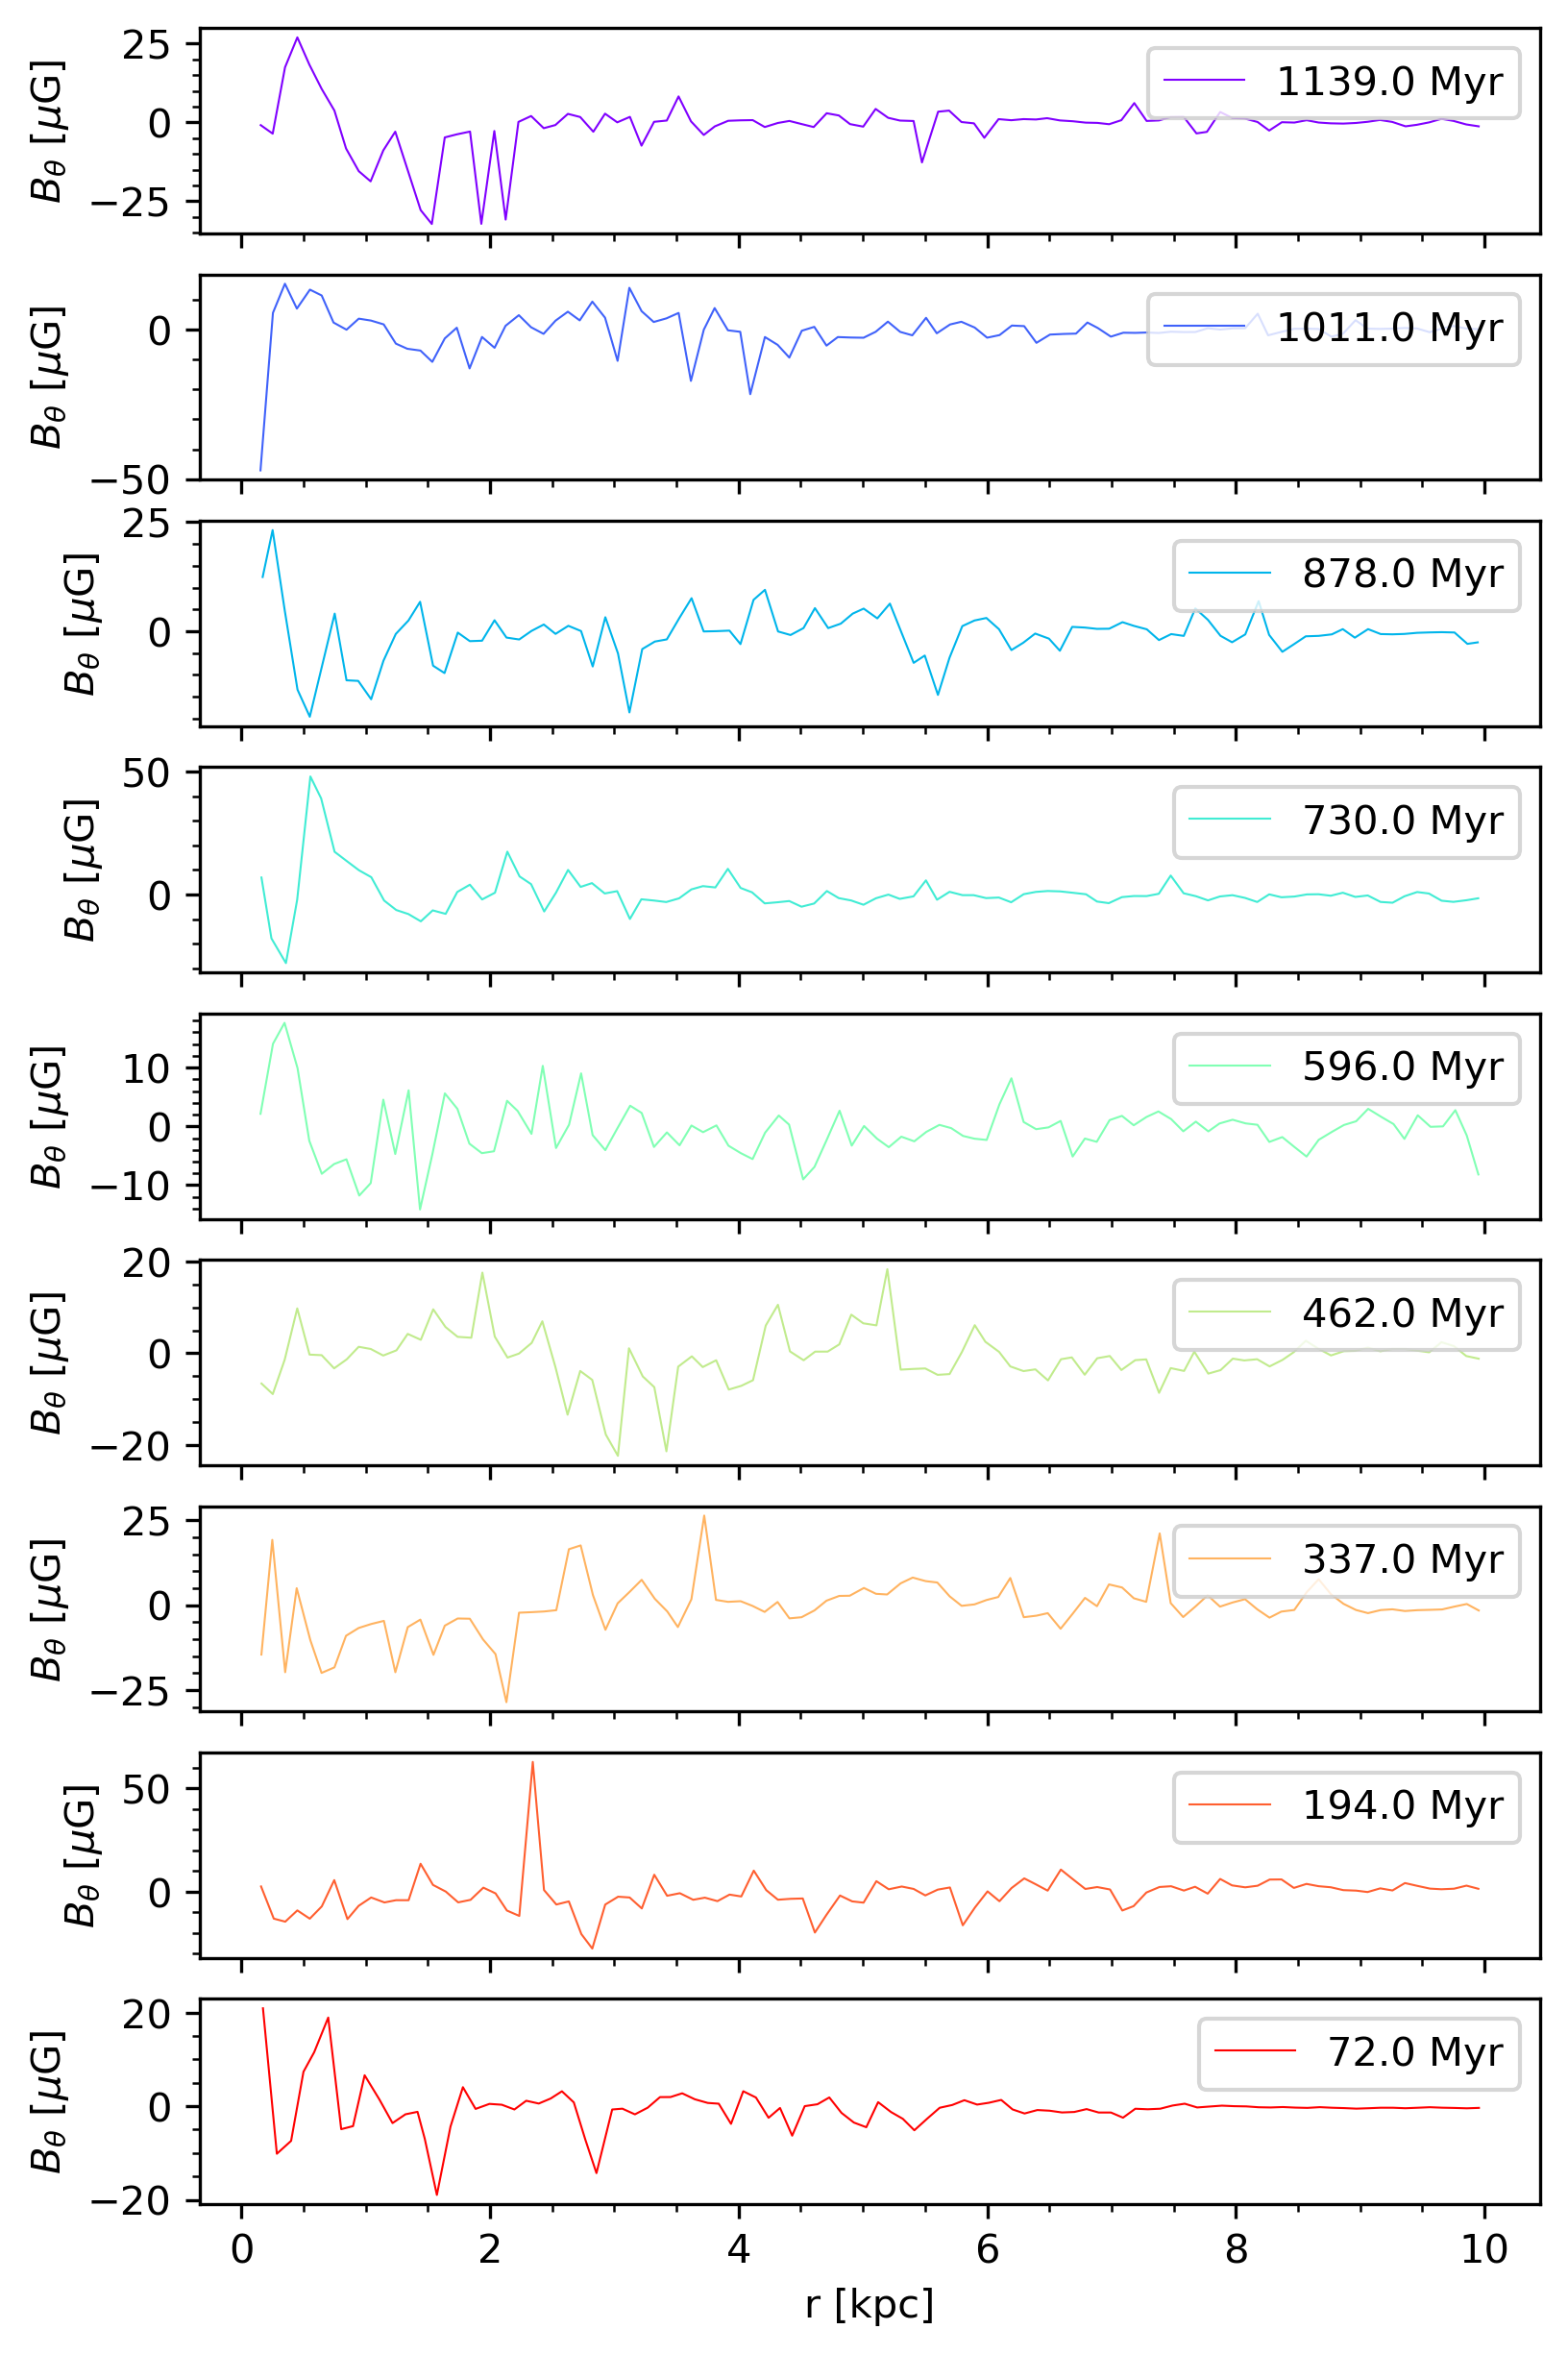

In [63]:
colors = cm.rainbow(np.linspace(0, 1, len(times)))[::-1]
fig, axs = plt.subplots(nrows=len(times), ncols=1, sharex=True, figsize=(6,10), dpi=300)

for i, ax in enumerate(axs.flatten()[::-1]):
    dat=datas[i]
    with pynbody.analysis.angmom.faceon(dat):
        rmax = 10.0
        hmax = 3.0
        disc = dat[pynbody.filt.Disc(radius = '%f kpc' %(rmax), 
                                     height= '%f kpc' %(hmax))]

        p = pynbody.analysis.profile.Profile(disc.gas, rmin=0.1, nbins=100)

        pl = ax.plot(p['r'], p['Btxy_uG'], lw=0.5, color=colors[i], label=f'{np.around(times[i])} Myr')
        ax.set(ylabel=r'$B_{\theta}$ [$\mu$G]')
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.legend(loc='upper right')

axs.flatten()[-1].set(xlabel='r [kpc]')
# plt.savefig('plots/B_norm_prof_new.pdf')
plt.show()